# General Functions

In [2]:
!git pull
import time
import multiprocessing as mp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
from SeqRep.pipeline import HomologousSequencePipeline, RNASequencePipeline
from SeqRep.visualize import reprs_by_label

def load(kind, path: str):
    p = kind.load(path)
    p.load_dataset(['SILVA_138.1_SSURef_NR99_tax_silva.fasta'], header_parser='SILVA')
    return p

class Visualizer:
    def __init__(self, p, axes: tuple):
        self.p = p
        self.axes = axes
        self.mask = p.dataset['labels'].apply(lambda i: len(i) == 7)
        self.reprs = p.reprs[self.mask][..., self.axes]
        self.ds = p.dataset[self.mask]
    
    def vis_domain(self):
        reprs_by_label(self.reprs, self.ds, 'Domain', 'Representations by Domain', savepath='out.png')
        plt.close()
        
    def vis_phylum(self):
        mask2 = self.p.dataset['labels'][self.mask].label_mask('Domain', 'Bacteria')
        reprs_by_label(self.reprs, self.ds, 'Phylum', 'Representations by Phylum', savepath='out.png', mask=mask2,
                       filter=2000)
        plt.close()
        
def rolling_average(arr, width):
    return np.convolve(arr, np.ones(width), 'valid') / width

class Search:
    def __init__(self, p, program: str):
        self.p = p
        self.program = program
        self.query = None
        self.results, results_names, results_tax = None, None, None
        self.dists = None
        self.program_output = None
        self.positive_hits = None
        self.program_names = None
        
    def gen_query(self):
        rng = np.random.default_rng()
        self.query = rng.choice(self.p.dataset['seqs'], 1)[0]
        with open('query.fasta', 'w') as f:
            f.write('>query\n')
            f.write(self.query)
        print(f'The query is {len(self.query)} base pairs long.')
        
    def run_program(self):
        if self.program == 'BLAST':
            !source blast-search.sh
            self.program_output = pd.read_csv('blast-results.csv', names=['query', 'name', 'pct_ident', 'score'] +
                                              [f'unk{i}' for i in range(6)] + ['e_value', 'bit_score'])
            self.program_output = self.program_output[:500]
        if self.program == 'SSEARCH':
            pairs = zip([self.query] * len(p.dataset), p.preproc_reprs)
            with mp.Pool(120) as pool:
                aln = np.fromiter(tqdm(pool.imap(p.model.distance.transform, pairs, chunksize=32),
                                       total=len(p.dataset)), dtype=np.float64)
            self.sort = np.argsort(aln)[::-1]
            sort = self.sort[:500]
            self.program_output = pd.DataFrame({
                'name': p.dataset.iloc[sort]['raw_headers'].apply(lambda i: i.split(' ')[0]),
                'score': aln[sort]
            })
            
    def my_results(self):
        start = time.time()
        self.dists, self.results = p.search(self.query, n_neighbors=500)
        print('My total search time: ', time.time() - start)

        self.dists = self.dists.flatten()
        self.results_names = np.array([i['raw_headers'].split(' ')[0] for i in self.results])
        self.results_tax = np.array([i['labels'] for i in self.results])
        
    def calc_positive_hits(self):
        self.program_names = self.program_output['name'].tolist()
        self.positive_hits = np.array([i in self.program_names for i in self.results_names])
        first_zero = list(self.positive_hits.astype(np.int64)).index(0)
        print(f'Num hits: {np.sum(self.positive_hits)}, Contiguous matches: {first_zero}')
        
    def plot_hit_rate(self):
        hit_rate = rolling_average(self.positive_hits, 25)
        plt.plot(hit_rate)
        plt.title('Average Search Hit Rate')
        plt.xlabel('Result Number')
        plt.ylabel('Fraction of NN Results Also Returned by BLAST')
        plt.ylim([0, 1])
        plt.savefig('out.png')
        plt.close()
        return hit_rate
        
    def plot_hit_err(self):
        hit_locs = np.array([[idx, self.program_names.index(val)] for idx, val in enumerate(self.results_names) \
                             if val in self.program_names])
        hit_errors = np.abs(hit_locs[:, 1] - hit_locs[:, 0])
        plt.plot(rolling_average(hit_errors, 10))
        plt.title('Search Hit Error Rate')
        plt.xlabel('Search Hit Number')
        plt.ylabel('Difference Between Positions in Both Searches')
        plt.ylim([0, 500])
        plt.savefig('out.png')
        plt.close()
        return hit_errors
        
    def pipeline(self):
        self.gen_query()
        self.run_program()
        self.my_results()
        self.calc_positive_hits()

Already up to date.


# Nucleotide Sequence Pipeline Test

In [ ]:
p = RNASequencePipeline()
p.load_dataset(['SILVA_138.1_SSURef_NR99_tax_silva.fasta'], header_parser='SILVA')
p.create_model(repr_size=2, res='ultra')

In [ ]:
p.dataset = p.dataset[p.dataset['labels'].label_mask('Domain', 'Bacteria')]

In [5]:
p.fit(batch_size=256, epochs=100, jobs=120, chunksize=256)

100%|██████████| 390847/390847 [00:55<00:00, 6986.65it/s] 


1527/1527 [==============================] - 914s 589ms/step - loss: 0.2197
Epoch time: 977.6578145027161
Epoch 2:


100%|██████████| 390847/390847 [00:57<00:00, 6810.17it/s] 


1527/1527 [==============================] - 901s 590ms/step - loss: 0.1953
Epoch time: 980.2642908096313
Epoch 3:


100%|██████████| 390847/390847 [00:57<00:00, 6750.11it/s] 


1527/1527 [==============================] - 904s 592ms/step - loss: 0.1892
Epoch time: 981.9225478172302
Epoch 6:


100%|██████████| 390847/390847 [00:57<00:00, 6850.58it/s] 


1527/1527 [==============================] - 903s 592ms/step - loss: 0.1910
Epoch time: 979.7260270118713
Epoch 7:


100%|██████████| 390847/390847 [00:57<00:00, 6818.89it/s] 


 390/1527 [======>.......................] - ETA: 11:11 - loss: 0.1879

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1527/1527 [==============================] - 904s 592ms/step - loss: 0.1878
Epoch time: 980.750390291214
Epoch 9:


100%|██████████| 390847/390847 [00:58<00:00, 6659.77it/s] 


1527/1527 [==============================] - 903s 591ms/step - loss: 0.1785
Epoch time: 978.5508103370667
Epoch 15:


100%|██████████| 390847/390847 [00:56<00:00, 6908.62it/s] 


1527/1527 [==============================] - 904s 592ms/step - loss: 0.1797
Epoch time: 975.4108679294586
Epoch 16:


100%|██████████| 390847/390847 [01:02<00:00, 6222.24it/s] 


1527/1527 [==============================] - 903s 591ms/step - loss: 0.1777
Epoch time: 988.9769446849823
Epoch 17:


100%|██████████| 390847/390847 [00:57<00:00, 6856.10it/s] 


1527/1527 [==============================] - 903s 591ms/step - loss: 0.1798
Epoch time: 979.5198075771332
Epoch 18:


100%|██████████| 390847/390847 [01:02<00:00, 6240.39it/s] 


1527/1527 [==============================] - 903s 591ms/step - loss: 0.1775
Epoch time: 989.0352449417114
Epoch 19:


100%|██████████| 390847/390847 [00:57<00:00, 6818.64it/s] 


1527/1527 [==============================] - 903s 591ms/step - loss: 0.1769
Epoch time: 975.8524498939514
Epoch 20:


100%|██████████| 390847/390847 [00:57<00:00, 6838.83it/s] 


1527/1527 [==============================] - 904s 592ms/step - loss: 0.1753
Epoch time: 980.3494229316711
Epoch 21:


100%|██████████| 390847/390847 [00:56<00:00, 6859.12it/s] 


1527/1527 [==============================] - 903s 592ms/step - loss: 0.1757
Epoch time: 977.3833250999451
Epoch 22:


100%|██████████| 390847/390847 [01:03<00:00, 6170.05it/s] 


1527/1527 [==============================] - 903s 591ms/step - loss: 0.1736
Epoch time: 991.5742835998535
Epoch 23:


100%|██████████| 390847/390847 [00:57<00:00, 6851.92it/s] 


 391/1527 [======>.......................] - ETA: 11:11 - loss: 0.1735

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1527/1527 [==============================] - 903s 591ms/step - loss: 0.1737
Epoch time: 987.9496505260468
Epoch 27:


100%|██████████| 390847/390847 [01:01<00:00, 6356.69it/s] 


1527/1527 [==============================] - 903s 591ms/step - loss: 0.1736
Epoch time: 989.6142208576202
Stopping early due to lack of improvement!
Total time taken: 26511.027416467667 seconds.
Transforming dataset...
1686/1686 [==============================] - 106s 62ms/step


100%|██████████| 431575/431575 [01:05<00:00, 6606.45it/s] 


In [ ]:
p.save('Models/silva-pipeline-nucl-ulres-baconly-2d')

In [2]:
p = load(RNASequencePipeline, 'Models/silva-pipeline-nucl-ulres-baconly-2d')

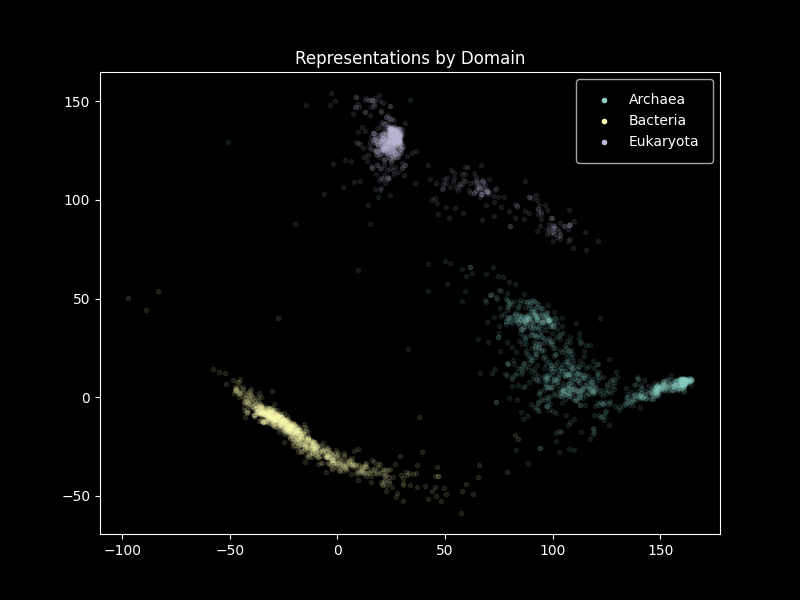

In [16]:
v = Visualizer(p, (0, 1))
v.vis_domain()
Image('out.png')

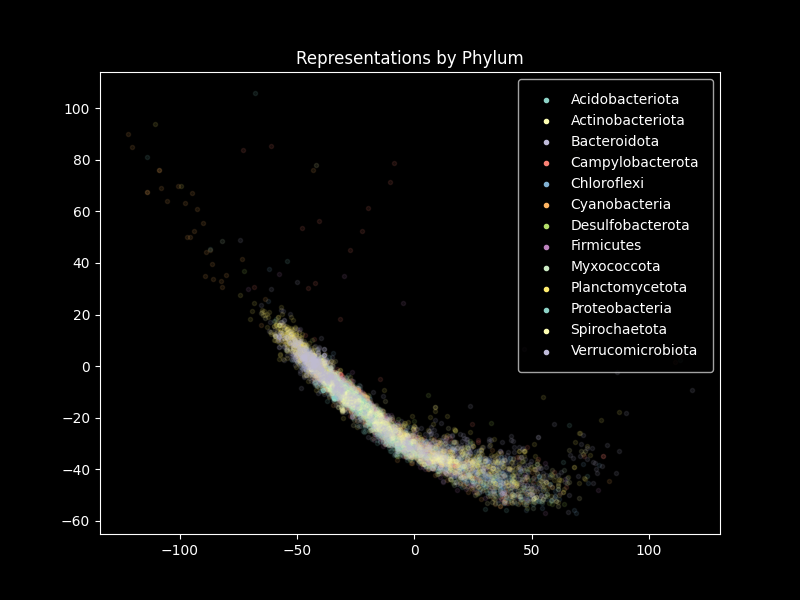

In [17]:
v.vis_phylum()
Image('out.png')

In [87]:
s = Search(p, 'SSEARCH')
s.pipeline()

The query is 1340 base pairs long.


  0%|          | 0/510508 [00:00<?, ?it/s]

1/1 [==============================] - 0s 258ms/step
My total search time:  0.9766891002655029
Num hits: 112, Contiguous matches: 7


/tmp/ipykernel_2822213/4251306754.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.results_tax = np.array([i['labels'] for i in self.results])


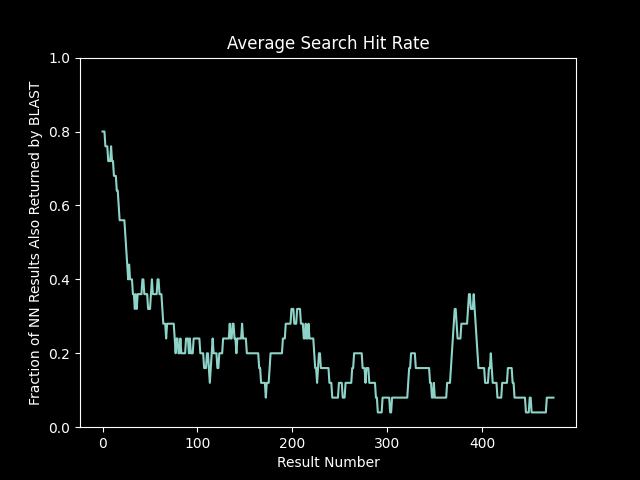

In [88]:
hit_rate = s.plot_hit_rate()
Image('out.png')

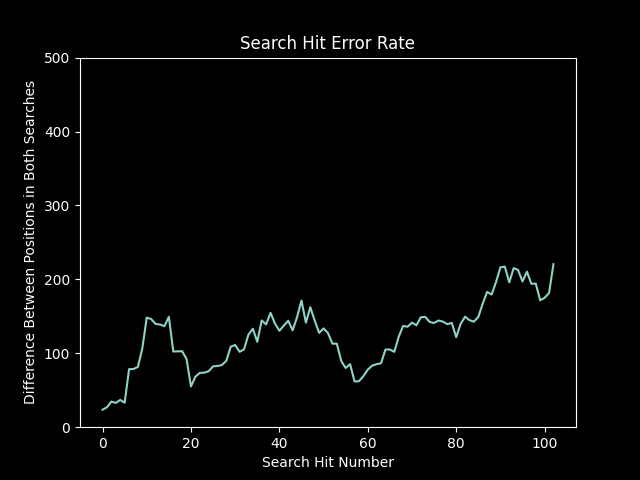

In [89]:
hit_err = s.plot_hit_err()
Image('out.png')

In [263]:
from scipy.spatial.distance import euclidean
def my_euclidean(pair):
    return euclidean(*pair)

enc = p.transform([s.query], 256)[0]
pairs = zip([enc] * len(p.dataset), p.reprs)
with mp.Pool(16) as pool:
    my_dists = np.fromiter(tqdm(pool.imap(my_euclidean, pairs, chunksize=512), total=len(p.dataset)),
                          dtype=np.float64)
sort = np.argsort(my_dists)

1/1 [==============================] - 0s 252ms/step


  0%|          | 0/510508 [00:00<?, ?it/s]

In [264]:
from sklearn.metrics import ndcg_score
my_sort = sort[:500]
maxidx = len(s.sort) - 1
minidx = maxidx - len(my_sort)
pred_relevances = np.arange(maxidx, minidx, -1)
# pred_relevances = np.arange(499, -1, -1)
# pred_relevances = np.arange(maxidx, -1, -1)

# li = list(s.sort)
# true_relevances = np.fromiter((li.index(i) for i in tqdm(my_sort)), dtype=np.int64)
# true_relevances = len(s.sort) - true_relevances - 1
# true_relevances = np.where(true_relevances < minidx, 0, true_relevances - minidx)
sorter = np.argsort(s.sort)
true_relevances = np.searchsorted(s.sort, my_sort, sorter=np.argsort(s.sort))
true_relevances = sorter[true_relevances]
true_relevances = len(s.sort) - true_relevances - 1

pred_relevances = pred_relevances / len(s.sort)
true_relevances = true_relevances / len(s.sort)

final_score = ndcg_score([true_relevances], [pred_relevances], ignore_ties=True)
final_score

0.9994898873800033

In [265]:
true_relevances

array([0.99999804, 0.99999608, 0.99989422, 0.99999216, 0.99988051,
       0.99994319, 0.99986288, 0.99891677, 0.9985583 , 0.99998041,
       0.99999412, 0.99990598, 0.99991185, 0.99981979, 0.99990793,
       0.99988835, 0.99993144, 0.99903038, 0.99983546, 0.99696381,
       0.99872676, 0.99762589, 0.99989814, 0.99944369, 0.9990676 ,
       0.99992556, 0.99992361, 0.99810385, 0.99999021, 0.99997845,
       0.99752012, 0.99965329, 0.99895202, 0.99994711, 0.95916812,
       0.99979824, 0.99866212, 0.99986484, 0.99961999, 0.99888738,
       0.99976298, 0.99794714, 0.9982821 , 0.9996337 , 0.99873068,
       0.99891481, 0.99446042, 0.99978061, 0.99515385, 0.99801962,
       0.99877573, 0.99828994, 0.99994907, 0.99777868, 0.9999667 ,
       0.99563964, 0.99894615, 0.99885408, 0.99788838, 0.99946916,
       0.99879924, 0.99990206, 0.99971989, 0.9997003 , 0.99866408,
       0.99919296, 0.99966896, 0.99836633, 0.99836437, 0.9988247 ,
       0.99777672, 0.99893831, 0.99749661, 0.99786095, 0.99809

# Homologous Sequence Pipeline Test

In [3]:
from SeqRep.pipeline import HomologousSequencePipeline
p = HomologousSequencePipeline()
p.load_dataset(['SILVA_138.1_SSURef_NR99_tax_silva.fasta'], header_parser='SILVA')
p.create_converter(jobs=16, chunksize=100)
p.create_model(repr_size=64, res='ultra')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 1629)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 1629, 20)          460       
                                                                 
 reshape_3 (Reshape)         (None, 20, 1629)          0         
                                                                 
 dense_5 (Dense)             (None, 20, 1629)          2655270   
                                                                 
 reshape_4 (Reshape)         (None, 1629, 20)          0         
                                                           

In [4]:
p.fit(batch_size=256, epochs=100, jobs=120, chunksize=512)

Preprocessing dataset...


100%|██████████| 510508/510508 [00:05<00:00, 98894.30it/s] 


Converting to amino acid sequences...


100%|██████████| 510508/510508 [00:09<00:00, 53728.81it/s]


Epoch 1:


100%|██████████| 468309/468309 [01:08<00:00, 6869.55it/s] 


1830/1830 [==============================] - 1046s 563ms/step - loss: 0.0510
Epoch time: 1149.3136231899261
Epoch 2:


100%|██████████| 468309/468309 [01:01<00:00, 7625.27it/s] 


1478/1830 [=======================>......] - ETA: 3:18 - loss: 0.0297

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1830/1830 [==============================] - 1032s 564ms/step - loss: 0.0202
Epoch time: 1128.64422082901
Epoch 6:


100%|██████████| 468309/468309 [01:03<00:00, 7409.74it/s] 


1830/1830 [==============================] - 1031s 563ms/step - loss: 0.0184
Epoch time: 1130.1771874427795
Epoch 7:


100%|██████████| 468309/468309 [00:59<00:00, 7818.01it/s] 


1830/1830 [==============================] - 1030s 563ms/step - loss: 0.0171
Epoch time: 1129.7480254173279
Epoch 8:


100%|██████████| 468309/468309 [01:01<00:00, 7560.23it/s] 


1830/1830 [==============================] - 1031s 563ms/step - loss: 0.0163
Epoch time: 1133.6678338050842
Epoch 9:


100%|██████████| 468309/468309 [01:00<00:00, 7720.43it/s] 


1830/1830 [==============================] - 1029s 562ms/step - loss: 0.0155
Epoch time: 1128.3732595443726
Epoch 10:


100%|██████████| 468309/468309 [01:00<00:00, 7744.43it/s] 


1830/1830 [==============================] - 1029s 562ms/step - loss: 0.0147
Epoch time: 1130.0648865699768
Epoch 12:


100%|██████████| 468309/468309 [01:00<00:00, 7789.87it/s] 


1352/1830 [=====================>........] - ETA: 4:29 - loss: 0.0143

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [216]:
p.save('Models/silva-pipeline-ulres-64d')

In [3]:
p = load(HomologousSequencePipeline, 'Models/silva-pipeline-ulres-64d')

In [ ]:
v = Visualizer(p, (31, 32))
v.vis_domain()
v.vis_phylum()

In [ ]:
s = Search(p, 'BLAST')
s.pipeline()